In [1]:
import os
os.chdir("..")

In [2]:
import torch
from diffusers.pipelines import FluxPipeline
from src.flux.condition import Condition
from PIL import Image

from src.flux.generate import generate, seed_everything
os.listdir()

['.git',
 'assets',
 'examples',
 'LICENSE',
 'outputs',
 'README.md',
 'requirements.txt',
 'src',
 'train']

In [ ]:
pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
for condition_type in ["coloring"]:
    pipe.load_lora_weights(
        "Yuanshi/OminiControl",
        weight_name=f"experimental/{condition_type}.safetensors",
        adapter_name=condition_type,
    )

In [ ]:
remove_format = 80
vid_path = "assets/input/drapeau/"
prompt = ("Photograph of flags floating in the sky. United Kingdom.")

for img_path in os.listdir(vid_path):
    input = Image.open(vid_path + img_path).convert("RGB")
    W, H = input.size
    input = input.crop(
        (remove_format, 0, W-remove_format, H)
    )
    w, h = input.size
    s = max(h,w)
    image = Image.new("RGB", (s, s), (0, 0, 0))  # RGB (0, 0, 0) is black
    paste_x = (s - w) // 2
    paste_y = (s - h) // 2
    image.paste(input, (paste_x, paste_y))
    image = image.resize((512,512))

    condition = Condition("coloring", image)
    seed_everything()
    result_img = generate(
        pipe,
        prompt=prompt,
        conditions=[condition]
    ).images[0]

    output = result_img.resize((s,s)).crop((paste_x, paste_y, paste_x + w, paste_y + h)) 
    source_img_lab = input.convert("LAB")
    target_img_lab = output.convert("LAB")
            
    source_l, source_a, source_b = source_img_lab.split()
    target_l, target_a, target_b = target_img_lab.split()
            
    new_l = source_l
    new_img_lab = Image.merge("LAB", (new_l, target_a, target_b))
    output = new_img_lab.convert("RGB")

    reformat = Image.new("RGB", (W, H), (0, 0, 0))  # RGB (0, 0, 0) is black
    reformat.paste(output, (remove_format, 0))
    reformat.save("outputs/croquet/"+img_path)


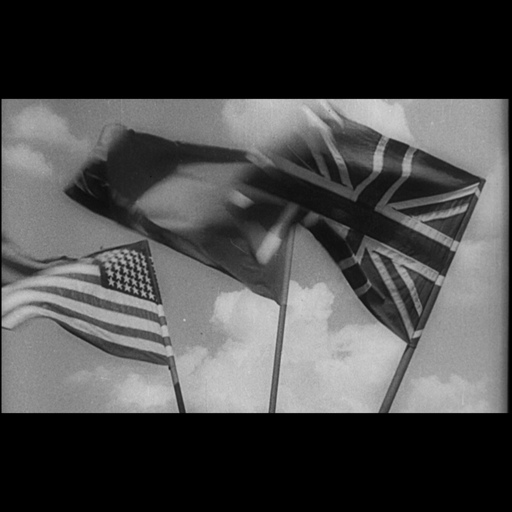

In [ ]:
add_borders = True
remove_format = 80
crop_center = False
#either add borders on the sides to make a square, either crop center of image, either reshape and flatten image to fit in square

img_path = "assets/input.png"
prompt = ("Photograph of flags floating in the sky. United Kingdom.")

input = Image.open(img_path).convert("RGB")
W, H = input.size
input = input.crop(
    (remove_format, 0, W-remove_format, H)
)
w, h = input.size
if add_borders:
    s = max(h,w)
    image = Image.new("RGB", (s, s), (0, 0, 0))  # RGB (0, 0, 0) is black
    paste_x = (s - w) // 2
    paste_y = (s - h) // 2
    image.paste(input, (paste_x, paste_y))
    image = image.resize((512,512))

elif crop_center:
    w, h, min_dim = input.size + (min(input.size),)
    image = input.crop(
        ((w - min_dim) // 2, (h - min_dim) // 2, (w + min_dim) // 2, (h + min_dim) // 2)
    ).resize((512, 512))

else:
    #image = input.crop((250,0,1670,1080))
    image = input
    w, h = image.size

image

In [21]:
condition = Condition("coloring", image.convert("L"))

seed_everything()

if add_borders or crop_center:
        result_img = generate(
            pipe,
            prompt=prompt,
            conditions=[condition]
        ).images[0]

else:
    result_img = generate(
        pipe,
        prompt=prompt,
        conditions=[condition],
        height = h,
        width = w
    ).images[0]
    output = Image.new("RGB", (w, h))
    output.paste(result_img, (0,0))
    #output.save("outputs/" + image_path)
    output.save("outputs/output.png")

  0%|          | 0/28 [00:00<?, ?it/s]

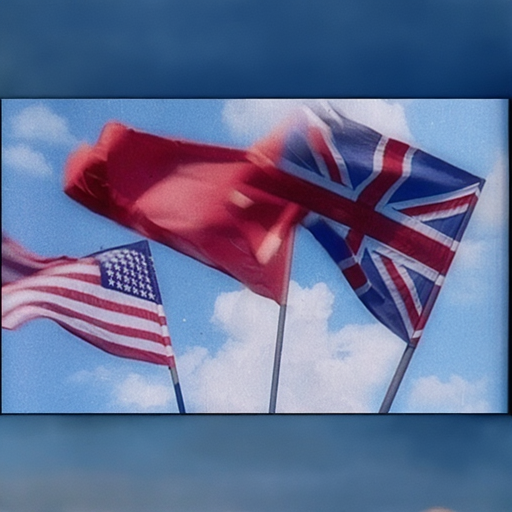

In [22]:
result_img

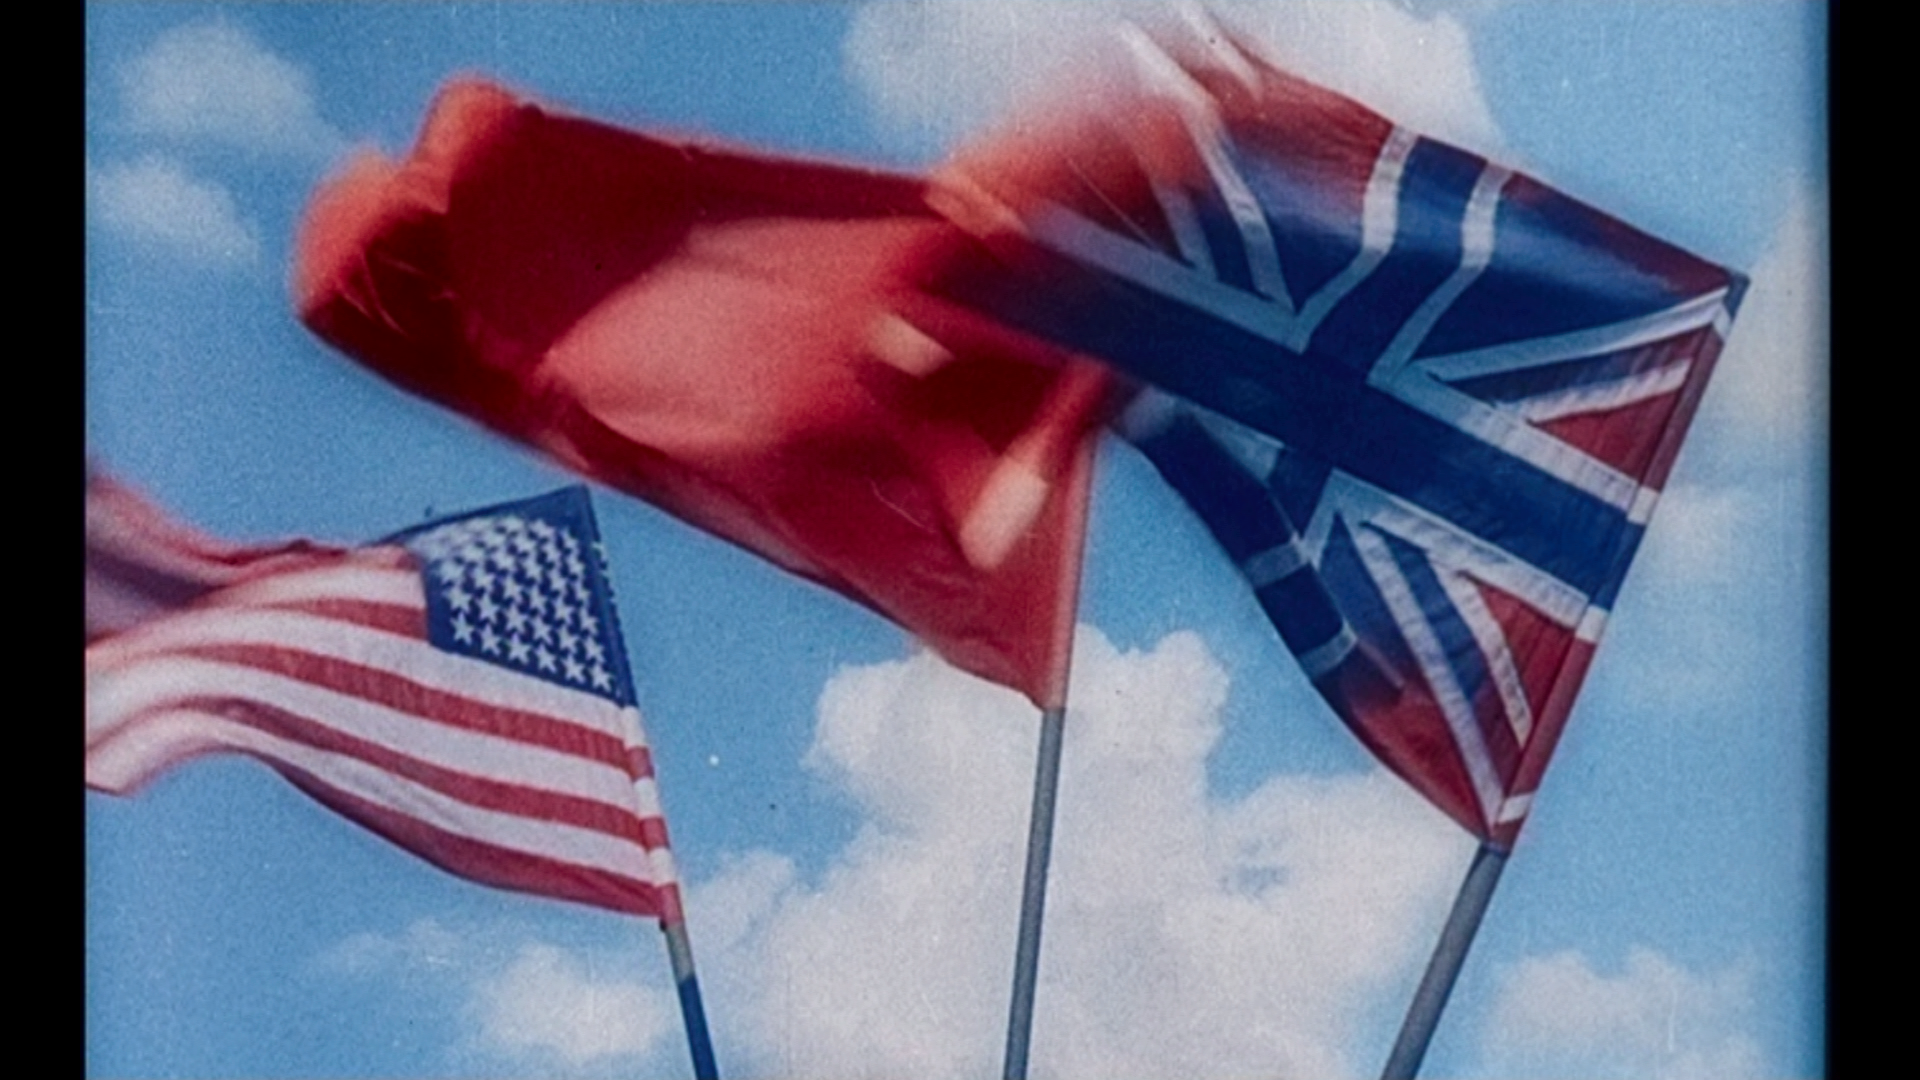

In [ ]:
if add_borders:
    output = result_img.resize((s,s)).crop((paste_x, paste_y, paste_x + w, paste_y + h)) 
    source_img_lab = input.convert("LAB")
    target_img_lab = output.convert("LAB")
        
    source_l, source_a, source_b = source_img_lab.split()
    target_l, target_a, target_b = target_img_lab.split()
        
    new_l = source_l
    new_img_lab = Image.merge("LAB", (new_l, target_a, target_b))
    output = new_img_lab.convert("RGB")

    reformat = Image.new("RGB", (W, H), (0, 0, 0))  # RGB (0, 0, 0) is black
    reformat.paste(output, (remove_format, 0))
    reformat.save("outputs/output.png")
    output = reformat

elif crop_center:
    output = Image.new("RGB", (512,512))
    output.paste(result_img, (0, 0))


else:
    output = Image.new("RGB", (w, h))
    output.paste(result_img, (0,0))

output